# Clustering Early Meccan Suras discussing *sirat*
Version: 17.03.2025  
by: Thomas Jurczyk  

This notebook includes:

1. An overview and exploratory data analysis of the subchapter data that should be clustered.
2. The retrieval of document embeddings for each subchapter.
3. Clustering of the documents using the retrieved embeddings.

In [1]:
# imports
import os
import pickle 
import matplotlib.pyplot as plt
import re
import pandas as pd
from mistralai import Mistral
from dotenv import load_dotenv
import psycopg2
from psycopg2 import sql
import numpy as np
import umap
from sklearn.cluster import HDBSCAN
from typing import Optional
import requests

# Apply a style
plt.style.use('ggplot')

# Loading all env variables from .env
load_dotenv()

MISTRAL_API_KEY = os.getenv("MISTRAL_API_KEY")

# Loading params for DB connection to local PostgreSQL

db_params = {
    "host": "localhost",
    "port": "5432",
    "database": os.getenv("DB_NAME"),
    "user": os.getenv("DB_USERNAME"),
    "password": os.getenv("DB_PASSWORD")
}

/home/tommy/environments/a01/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data
The data consists of subchapters from the A01 tafsir corpus that include a discussion of early Meccan verses that mention *sirat*. The data was downloaded using the web application and is stored in the subfolder `data`.

### Tokens per subchapter
First, we count the number of tokens in each subchapter and compare the results with each other. A token is simply defined by at least one blank space separating the tokens. The tokens are not cleaned of non-Arabic characters and still include punctuation marks as well (these might in some cases count as separate tokens as well due to the way the data was collected and reconstructed).

In [ ]:
token_counter = dict()
token_counter_per_verse = dict()
for directory in os.listdir("data"):
    if os.path.isdir("data/"+directory) and not directory.startswith("."):
        file_counter = 0
        token_counter_per_verse[directory] = 0
        #print("data/"+directory)
        for filename in os.listdir("data/"+directory):
            #print(filename)
            # Create separate dict for tokens/verse distribution
            if os.path.isfile(f"data/{directory}/{filename}"):
                file_counter += 1
                with open(f"data/{directory}/{filename}", "r", encoding="utf-8") as f:
                    text = f.read()
                    tokens = re.split(r"\s+", text)
                    token_counter[filename[:-4]] = len(tokens)
                    # Increment tokens/verse counter
                    token_counter_per_verse[directory] += len(tokens)
        # Calculate average for token/verse
        token_counter_per_verse[directory] = token_counter_per_verse[directory] / file_counter

In [ ]:
df = pd.DataFrame.from_dict(token_counter, orient="index").reset_index()

In [ ]:
df.columns = ["id", "token_count"]

In [ ]:
df.head()

In [ ]:
df.describe()

In [ ]:
df["token_count"].plot(kind="box", title="Token distribution in subchapters", color="skyblue")

plt.savefig("images/boxplot.jpg")

In [ ]:
# show outliers and exclude (Sirazi)
df_no_sirazi = df.sort_values("token_count").iloc[:-1]

In [ ]:
df_no_sirazi.describe()

In [ ]:
df_no_sirazi["token_count"].plot(kind="box", title="Token distribution in subchapters (without Sirazi)", color="skyblue")

plt.savefig("images/boxplot_no_sirazi.jpg")

### Token distribution per verse

In [ ]:
df = pd.DataFrame.from_dict(token_counter_per_verse, orient="index").reset_index()

In [ ]:
df.columns = ["sura_aya", "count"]

In [ ]:
df

In [ ]:
df.sort_values("count")

In [ ]:
ax = df.sort_values("count", ascending=False).plot(kind="bar", x="sura_aya", title="Avg. token/subchapter distribution for each verse", color="skyblue")
# Display count on top of each bar
for bar in ax.patches:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, round(yval, 2), ha='center', va='bottom')

plt.ylim(0,6500)
plt.ylabel("avg. tokens")

plt.tight_layout()

plt.savefig("images/token_verse_distribution.jpg")

## Embeddings
In a first step, we are acquiring the embeddings using Mistral's `mistral-embed` model.

### Full Subchapter Embeddings

We are creating three lists for the text ids, texts, and the embeddings. Some subchapters appear multiple times in the dataset, so the duplicates need to be skipped.

In [ ]:
sc_id_list = []
sc_text_list = []
sc_embeddings_list = []

In [ ]:
for directory in os.listdir("data"):
    if os.path.isdir("data/"+directory) and not directory.startswith("."):
        #print("data/"+directory)
        for filename in os.listdir("data/"+directory):
            # Create separate dict for tokens/verse distribution
            if os.path.isfile(f"data/{directory}/{filename}"):
                if filename[:-4] not in sc_id_list:
                    file_counter += 1
                    with open(f"data/{directory}/{filename}", "r", encoding="utf-8") as f:
                        text = f.read()
                        sc_id_list.append(filename[:-4])
                        sc_text_list.append(text)

In [ ]:
sc_id_list[:3]

Now, we are retrieving the embeddings for each text and store them in the respective list.  
**Important**: The embeddings are afterwards stored in a database and locally on the computer. Therefore, this step only needs to be executed when something has changed.

In [ ]:
import time

model = "mistral-embed"
execute = False
client = Mistral(api_key=MISTRAL_API_KEY)

# The max token per batch is 16384 or sometimes even lower for some reason (?)
# We split longer texts into chunks
# Using a sliding window approach with an overlap of 50 tokens
# We also need to use time.sleep() to avoid exceeding rate limits with 6 requests per sec
if execute:
    for idx, text in enumerate(sc_text_list):
        #print(f"{idx}. {sc_id_list[idx]}")
        tokens = re.split(r"\s+", text)
        if len(tokens) > 1000:
            #print(f"Text {sc_id_list[idx]} is too long: {len(tokens)}") 
            tmp_embeddings = list()
            # Splitting the text into chunks
            window_size = 500
            stride = 450 # Overlap of 50 tokens
            for start_idx in range(0,len(tokens), stride):
                end_idx = min(start_idx + window_size, len(tokens))
                tmp_text = " ".join(tokens[start_idx:end_idx])
                res = client.embeddings.create(model=model, inputs=[tmp_text])
                tmp_embeddings.append(res.data[0].embedding)
                time.sleep(0.1)
            # Calculate mean from all chunk embeddings
            sc_embeddings_list.append(np.mean(tmp_embeddings, axis=0).tolist())
        else:
            res = client.embeddings.create(model=model, inputs=[text])
            sc_embeddings_list.append(res.data[0].embedding)
            time.sleep(0.1)

In [ ]:
# Saving embeddings locally

with open("mistral_embeddings_full.pkl", "wb") as f:
    pickle.dump(sc_embeddings_list, f)

In [ ]:
# Reload embeddings
with open("mistral_embeddings_full.pkl", "rb") as f:
    loaded_embeddings = pickle.load(f)

In [ ]:
# Connecting to PostgreSQL and storing embeddings in table

In [ ]:
try:
    conn = psycopg2.connect(**db_params)
    cursor = conn.cursor()
    print("Connection to DB was successful!!")

    for idx, value in enumerate(loaded_embeddings):
        cursor.execute("""
            INSERT INTO embedding.sc_mistral_fulltext (subchapter_id, embedding) 
            VALUES (%s, %s)
        """, (sc_id_list[idx], value))
    
        # Änderungen bestätigen
        conn.commit()
    print("Data was added!")

except Exception as e:
    print(f"Error: {e}")
    if conn:
        conn.rollback()
finally:
    # Close connection
    if cursor:
        cursor.close()
    if conn:
        conn.close()
    print("DB connection closed.")

### Test embeddings for Arabic texts: MSA
We will try and cluster simple Arabic texts to see if this even works.

In [ ]:
# Loading test data
df_test = pd.read_csv("arabic-test-data.csv")

In [ ]:
df_test.head()

In [ ]:
text_list = df_test["arabic_text"].tolist()

In [ ]:
text_list

In [ ]:
# Get embeddings
model = "mistral-embed"

client = Mistral(api_key=MISTRAL_API_KEY)

embeddings_batch_response = client.embeddings.create(
    model=model,
    inputs=text_list,
)

In [ ]:
embeddings_test = [entry.embedding for entry in embeddings_batch_response.data]

In [ ]:
embeddings_test[0][:10]

In [ ]:
# Add embeddings to database
db_test_params = {
    "host": "localhost",
    "port": "5432",
    "database": os.getenv("DB_NAME"),
    "user": os.getenv("DB_USERNAME"),
    "password": os.getenv("DB_PASSWORD")
}

try:
    conn = psycopg2.connect(**db_test_params)
    cursor = conn.cursor()
    print("Connection to DB was successful!!")

    for idx, row in df_test.iterrows():
        cursor.execute("""
            INSERT INTO embedding.test_embeddings (id, embedding, category, translation) 
            VALUES (%s, %s, %s, %s)
        """, (idx, embeddings_test[idx], row["category"], row["translation"]))
    
        # Änderungen bestätigen
        conn.commit()
    print("Data was added!")

except Exception as e:
    print(f"Error: {e}")
    if conn:
        conn.rollback()
finally:
    # Close connection
    if cursor:
        cursor.close()
    if conn:
        conn.close()
    print("DB connection closed.")

### Test embeddings for Arabic texts: Classical Arabic
We will try and cluster classical Arabic texts to see if this even works.

In [ ]:
# Loading test data
df_test = pd.read_csv("classical-arabic-testdata.csv")

In [ ]:
df_test.head()

In [ ]:
text_list = df_test["Arabic_Text"].tolist()

In [ ]:
text_list[:3]

In [ ]:
# Get embeddings
model = "mistral-embed"

client = Mistral(api_key=MISTRAL_API_KEY)

embeddings_batch_response = client.embeddings.create(
    model=model,
    inputs=text_list,
)

In [ ]:
embeddings_test = [entry.embedding for entry in embeddings_batch_response.data]

In [ ]:
# Add embeddings to database
db_test_params = {
    "host": "localhost",
    "port": "5432",
    "database": os.getenv("DB_NAME"),
    "user": os.getenv("DB_USERNAME"),
    "password": os.getenv("DB_PASSWORD")
}

try:
    conn = psycopg2.connect(**db_test_params)
    cursor = conn.cursor()
    print("Connection to DB was successful!!")

    for idx, row in df_test.iterrows():
        cursor.execute("""
            INSERT INTO embedding.test_embeddings_classical (id, embedding, category, translation) 
            VALUES (%s, %s, %s, %s)
        """, (idx, embeddings_test[idx], row["Category"], row["English_Translation"]))
    
        # Änderungen bestätigen
        conn.commit()
    print("Data was added!")

except Exception as e:
    print(f"Error: {e}")
    if conn:
        conn.rollback()
finally:
    # Close connection
    if cursor:
        cursor.close()
    if conn:
        conn.close()
    print("DB connection closed.")

## Dimensionality Reduction & Clustering
For easier plotting and comparison, we reduce the 1024 features from Mistral's embeddings to 2 features. We will be using umap for the dimensionality reduction.

First, we load the stored Mistral AI embeddings and the subchapter corpus.

In [14]:
# Load embeddings
loaded_embeddings = []
with open("mistral_embeddings_full.pkl", "rb") as f:
    loaded_embeddings = pickle.load(f)

In [15]:
# Loading texts and ids from drive
sc_dict = dict()
idx = 0
for directory in os.listdir("data"):
    if os.path.isdir("data/"+directory) and not directory.startswith("."):
        #print("data/"+directory)
        for filename in os.listdir("data/"+directory):
            # Create separate dict for tokens/verse distribution
            if os.path.isfile(f"data/{directory}/{filename}"):
                if filename[:-4] not in sc_dict:
                    sc_dict[filename[:-4]] = {"embedding": loaded_embeddings[idx]}
                    idx += 1

df = pd.DataFrame.from_dict(sc_dict, orient="index")

If we want, we can further filter the subchapter corpus, for instance by only selecting subchapters that discuss exactly one aya.

In [16]:
df.loc["sc.18_1_1_7"]

embedding    [-0.016387939453125, 0.03438377380371094, 0.06...
Name: sc.18_1_1_7, dtype: object

Next, we apply umap on the np.array version of the embeddings.

In [17]:
# First convert all lists to np.arrays, otherwise umap won't work
embeddings_orig = df["embedding"].to_numpy()
embeddings_orig = [np.array(l) for l in embeddings_orig]

In [18]:
#umap_reducer = umap.UMAP(n_neighbors=2, 
                         #min_dist=0.1, 
                         #n_components=2,
                         #metric="cosine",
                         #random_state=42)
umap_reducer = umap.UMAP(random_state=42)

In [19]:
embeddings_reduced = umap_reducer.fit_transform(embeddings_orig)

/home/tommy/environments/a01/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/tommy/environments/a01/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [42]:
df["reduced_embeddings"] = embeddings_reduced.tolist()

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 549 entries, sc.15_38_21_26 to sc.4_19_36_40
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   embedding           549 non-null    object
 1   cluster             549 non-null    int64 
 2   reduced_embeddings  549 non-null    object
dtypes: int64(1), object(2)
memory usage: 33.3+ KB


In [44]:
df.head()

,embedding,cluster,reduced_embeddings
sc.15_38_21_26,"[-0.009832461675008139, 0.013961315155029297, ...",0,"[6.408513069152832, 7.243328094482422]"
sc.89_38_22_22,"[-0.0335693359375, 0.022918701171875, 0.046356...",0,"[5.989302158355713, 6.010448932647705]"
sc.83_38_1_26,"[-0.006933484758649554, 0.018914358956473216, ...",0,"[6.875131130218506, 6.406745910644531]"
sc.95_38_21_24,"[-0.00994873046875, 0.01206207275390625, 0.043...",0,"[6.283421039581299, 7.552778244018555]"
sc.79_38_22_22,"[-0.0151824951171875, 0.027618408203125, 0.064...",0,"[6.4714579582214355, 6.3549675941467285]"


**TODO**: Evaluation of dimensionality reduction.

Next, we are using HDBSCAN to cluster the data.

In [21]:
hdbscan_clusterer = HDBSCAN()

cluster_labels = hdbscan_clusterer.fit_predict(embeddings_reduced)

In [22]:
# Adding cluster labels to dataframe
df["cluster"] = cluster_labels

In [23]:
df.groupby("cluster").count().sort_values("embedding", ascending=False).to_csv("tables/cluster_overview.csv")

Plotting the results.

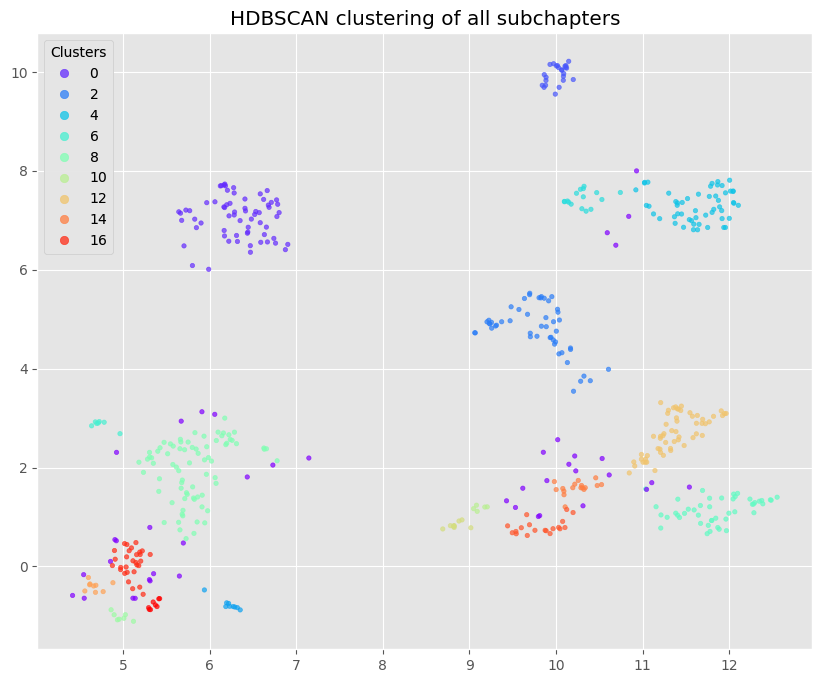

In [24]:
# Plot reduced datapoints
plt.figure(figsize=(10, 8))

# Create scatter plot
scatter = plt.scatter(embeddings_reduced[:, 0], 
            embeddings_reduced[:, 1], 
            c=cluster_labels, 
            cmap='rainbow', 
            s=10, 
            alpha=0.7)

# Add a legend for the clusters
legend1 = plt.legend(*scatter.legend_elements(),
                    title="Clusters")
plt.gca().add_artist(legend1)

# Title
plt.title("HDBSCAN clustering of all subchapters")

# Saving plot
plt.savefig("images/hdbscan_all.jpg")

## Retrieving texts of subchapters in each cluster

In [25]:
def download_subchapter_file(subchapter_id: str, filename: Optional[str] = None):
    # Build API path from sc_id
    # Example: http://localhost:8080/api/download/tafsir/3/c.3_2/sc.3_2_77_77
    url = "http://localhost:8080/api/download/tafsir/"
    sc_list = subchapter_id.split("_")
    tafsir_id = sc_list[0].split(".")[1]
    url += tafsir_id + "/"
    chapter_id = "c." + tafsir_id + "_" + sc_list[1]
    url += chapter_id + "/" + subchapter_id
    # DEBUG
    print(url)
    
    # Send request
    response = requests.get(url)
    
    # Check if request was successful
    response.raise_for_status()
    
    # Save file
    with open(filename, 'wb') as file:
        file.write(response.content)
    
    return filename

In [26]:
def download_cluster_subchapters(subchapter_list: list[str], path: str):
        if not os.path.exists(path):
            os.makedirs(path)
            print(f"Directory created: {path}")
        else:
            print(f"Directory already exists: {path}")
        for sc in subchapter_list:
            download_subchapter_file(sc, f"{path}/{sc}.txt")

In [28]:
#for i in df.cluster.unique():
   #download_cluster_subchapters(df[df["cluster"]==i].index.tolist(), f"clustering/{i}")

## Retrieving metadata for each subchapter in cluster

In [30]:
def get_subchapter_metadata(sc_id: str) -> (dict, str):
    # Get tafsir id from sc id
    # This is needed since the API only delivers metadata for tafsirs, not subchapters
    # sc ids should look like this: sc.1_2_1_7 where the tafsir id is the 1 in sc.1
    try:
        tafsir_id = sc_id.split("_")[0].split(".")[1].strip()
    except:
        return dict(), f"Could not parse tafsir id from sc id {sc_id}"
    if tafsir_id == "":
        return dict(), f"Could not parse tafsir id from sc id {sc_id}"
    res = requests.get(f"http://localhost:8080/api/metadata/overview/{tafsir_id}")
    try:
        res.raise_for_status()
    except:
        return dict(), f"Could not retrieve data via API for tafsir id {tafsir_id}"
    return res.json(), ""

In [31]:
# Save metadata for all clusters
for i in df.cluster.unique():
    data = dict()
    for idx, sc in enumerate(df[df["cluster"]==i].index.tolist()):
        json_res, err = get_subchapter_metadata(sc)
        # Adding sc id to JSON data
        json_res["sc_id"] = sc
        data[idx] = json_res
    df_metadata = pd.DataFrame.from_dict(data, orient="index")
    df_metadata = df_metadata.map(lambda x: "; ".join(x) if type(x) == list else x)
    df_metadata.to_csv(f"tables/cluster_{i}.csv")

## Re-clustering of subchapters in a specific cluster 12

In [45]:
df[df["cluster"] == 12].info()

<class 'pandas.core.frame.DataFrame'>
Index: 57 entries, sc.83_37_114_182 to sc.15_15_30_41
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   embedding           57 non-null     object
 1   cluster             57 non-null     int64 
 2   reduced_embeddings  57 non-null     object
dtypes: int64(1), object(2)
memory usage: 1.8+ KB


In [46]:
df_cp = df[df["cluster"] == 12].copy()

In [48]:
df_cp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 57 entries, sc.83_37_114_182 to sc.15_15_30_41
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   embedding           57 non-null     object
 1   cluster             57 non-null     int64 
 2   reduced_embeddings  57 non-null     object
dtypes: int64(1), object(2)
memory usage: 1.8+ KB


In [61]:
# Reconverting embeddings to numpy arrays
tmp = df_cp["reduced_embeddings"].to_numpy()
reduced_embeddings_subcluster = np.array([list(x) for x in tmp])

In [62]:
hdbscan_clusterer = HDBSCAN()

cluster_labels = hdbscan_clusterer.fit_predict(reduced_embeddings_subcluster)

In [63]:
df_cp["subcluster"] = cluster_labels

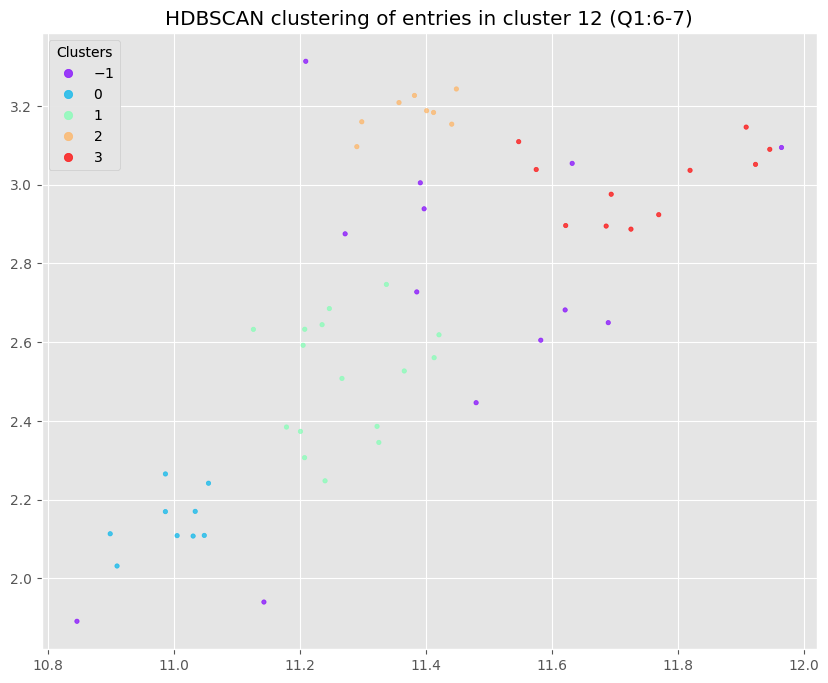

In [64]:
# Plot reduced datapoints
plt.figure(figsize=(10, 8))

# Create scatter plot
scatter = plt.scatter(reduced_embeddings_subcluster[:, 0], 
            reduced_embeddings_subcluster[:, 1], 
            c=cluster_labels, 
            cmap='rainbow', 
            s=10, 
            alpha=0.7)

# Add a legend for the clusters
legend1 = plt.legend(*scatter.legend_elements(),
                    title="Clusters")
plt.gca().add_artist(legend1)

# Title
plt.title("HDBSCAN clustering of entries in cluster 12 (Q1:6-7)")

# Saving plot
plt.savefig("images/hdbscan_subcluster_12.jpg")

In [72]:
## Saving files
for i in df_cp.subcluster.unique():
   download_cluster_subchapters(df_cp[df_cp["subcluster"]==i].index.tolist(), f"clustering/subcluster/{i}")

Directory created: clustering/subcluster/0
http://localhost:8080/api/download/tafsir/83/c.83_37/sc.83_37_114_182
http://localhost:8080/api/download/tafsir/22/c.22_37/sc.22_37_1_82
http://localhost:8080/api/download/tafsir/75/c.75_37/sc.75_37_1_23
http://localhost:8080/api/download/tafsir/15/c.15_37/sc.15_37_11_26
http://localhost:8080/api/download/tafsir/6/c.6_37/sc.6_37_11_23
http://localhost:8080/api/download/tafsir/17/c.17_37/sc.17_37_1_28
http://localhost:8080/api/download/tafsir/68/c.68_37/sc.68_37_11_26
http://localhost:8080/api/download/tafsir/90/c.90_37/sc.90_37_1_34
http://localhost:8080/api/download/tafsir/94/c.94_37/sc.94_37_11_26
Directory created: clustering/subcluster/1
http://localhost:8080/api/download/tafsir/54/c.54_37/sc.54_37_22_26
http://localhost:8080/api/download/tafsir/104/c.104_37/sc.104_37_22_50
http://localhost:8080/api/download/tafsir/95/c.95_37/sc.95_37_22_33
http://localhost:8080/api/download/tafsir/96/c.96_37/sc.96_37_19_28
http://localhost:8080/api/downlo

In [68]:
def get_subchapter_metadata(sc_id: str) -> (dict, str):
    # Get tafsir id from sc id
    # This is needed since the API only delivers metadata for tafsirs, not subchapters
    # sc ids should look like this: sc.1_2_1_7 where the tafsir id is the 1 in sc.1
    try:
        tafsir_id = sc_id.split("_")[0].split(".")[1].strip()
    except:
        return dict(), f"Could not parse tafsir id from sc id {sc_id}"
    if tafsir_id == "":
        return dict(), f"Could not parse tafsir id from sc id {sc_id}"
    res = requests.get(f"http://localhost:8080/api/metadata/overview/{tafsir_id}")
    try:
        res.raise_for_status()
    except:
        return dict(), f"Could not retrieve data via API for tafsir id {tafsir_id}"
    return res.json(), ""

In [71]:
# Save metadata for all clusters
for i in df_cp.subcluster.unique():
    data = dict()
    for idx, sc in enumerate(df_cp[df_cp["subcluster"]==i].index.tolist()):
        json_res, err = get_subchapter_metadata(sc)
        # Adding sc id to JSON data
        json_res["sc_id"] = sc
        data[idx] = json_res
    df_metadata = pd.DataFrame.from_dict(data, orient="index")
    df_metadata = df_metadata.map(lambda x: "; ".join(x) if type(x) == list else x)
    df_metadata.to_csv(f"tables/subcluster_{i}.csv")